In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Huawei Mate 20 Pro sold out during first round...,"Huawei has announced that Huawei Mate 20 Pro, ...",technology
1,OnePlus Lucky Star winner to get 600 gifts alo...,"OnePlus 'Lucky Star' campaign winner, Shashank...",technology
2,OnePlus' 5G phone to be among the first with a...,OnePlus has announced that their unnamed 2019 ...,technology
3,More than half the world will be online by yea...,The UN agency for information and communicatio...,technology
4,China state media calls Huawei CFO arrest a 'd...,China's state media called technology giant Hu...,technology
5,Huawei CFO was held while changing planes duri...,Chinese telecoms giant Huawei's CFO Meng Wanzh...,technology
6,HCL to buy 7 IBM products for $1.8 bn in its b...,Noida-based IT major HCL Technologies has said...,technology
7,Google rolls out gender-specific translation t...,Technology major Google has started rolling ou...,technology
8,Facebook to check Indian political ads before ...,Facebook has announced it will confirm the ide...,technology
9,Instagram faces glitch causing lines to appear...,Facebook-owned photo sharing app Instagram too...,technology


In [4]:
news_df.news_category.value_counts()

technology    25
world         25
sports        24
Name: news_category, dtype: int64

In [5]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata

In [7]:
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)

In [8]:
tokenizer = ToktokTokenizer()
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list.remove('no')
stopwords_list.remove('not')

## Remove HTML tags

In [9]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    stripped_text = soup.get_text()
    
    return stripped_text

strip_html_tags('<html><h2>I am the best data scientist</h2></html>')

'I am the best data scientist'

## Remove accented characters

In [10]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

## Expand contractions

In [11]:
def expand_contractions(text, contraction_mapping = CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags = re.IGNORECASE|re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
#         print('match : ', match)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
        expanded_contraction = first_char + expanded_contraction[1:]
        
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

## Remove special characters

In [12]:
def remove_special_characters(text, remove_digits=False):
    
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, "", text)
    
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", remove_digits=True)

'Well this was fun What do you think '

## Text lemmatization

In [13]:
def lemmatize_text(text):
    text = nlp(text)
    text = " ".join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

## Text stemming

In [14]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = " ".join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

## Remove stopwords¶

In [15]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords_list]
    filtered_text = " ".join(filtered_tokens)
    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Building a text normalizer

In [16]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    for doc in corpus:
        if html_stripping:
            doc = strip_html_tags(doc)
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        if contraction_expansion:
            doc = expand_contractions(doc)
        if text_lower_case:
            doc = doc.lower()
        doc = re.sub(r'[\r|\n|\r\n]+', " ", doc)
        
        if text_lemmatization:
            doc = lemmatize_text(doc)
        if special_char_removal:
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)              
        doc = re.sub(' +', " ", doc)
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [17]:
news_df['full_text'] = news_df['news_headline'].map(str) + '. ' + news_df['news_article']

In [18]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])

In [20]:
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text','clean_text']].to_dict()

{'clean_text': 'oneplus lucky star winner get gift along oneplus oneplus lucky star campaign winner shashank shekhar get additional free gift along oneplus purchase amazon exciting gift item range across category furniture appliance gadget fashion accessory wherein gift price amazon oneplus announce offer last week celebrate four year partnership',
 'full_text': "OnePlus Lucky Star winner to get 600 gifts along with OnePlus 6T . OnePlus 'Lucky Star' campaign winner, Shashank Shekhar, is getting 600 additional free gifts along with his OnePlus 6T purchase through Amazon. The exciting gift items range across categories such as furniture, appliances, gadgets and fashion accessories, wherein each gift is priced between ₹100 and ₹80,000. Amazon and OnePlus had announced the offer last week to celebrate their four year partnership."}

## Save the news articles

In [21]:
news_df.to_csv('news.csv', encoding='utf-8', index=False)

## Tagging Parts of Speech¶

In [22]:
news_df = pd.read_csv('news.csv')

In [24]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, text_lemmatization=False, special_char_removal=False)
sentence = str(news_df.iloc[1].news_headline)

In [26]:
sentence_nlp = nlp(sentence)
sentence_nlp

OnePlus Lucky Star winner to get 600 gifts along with OnePlus 6T 

In [28]:
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['word', 'POS', 'Tag Type'])

,word,POS,Tag Type
0,OnePlus,NNP,PROPN
1,Lucky,NNP,PROPN
2,Star,NNP,PROPN
3,winner,NN,NOUN
4,to,TO,PART
5,get,VB,VERB
6,600,CD,NUM
7,gifts,NNS,NOUN
8,along,IN,ADP
9,with,IN,ADP


In [30]:
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=["Word", "POS Tag"])

,Word,POS Tag
0,OnePlus,CC
1,Lucky,NNP
2,Star,NNP
3,winner,NN
4,to,TO
5,get,VB
6,600,CD
7,gifts,NNS
8,along,IN
9,with,IN


## Shallow Parsing or Chunking Text

In [33]:
from nltk.corpus import conll2000
data = conll2000.chunked_sents()

train_data = data[:10900]
test_data = data[10900:]
print(len(train_data), len(test_data))
print(train_data[1])

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [36]:
from nltk.chunk.util import conlltags2tree, tree2conlltags

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [38]:
tree = conlltags2tree(wtc)
print(tree)

(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [40]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]

    return [[(t, c) for (w,t,c) in sent] for sent in tagged_sents]

def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
        
    return backoff

In [41]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

class NGramTagChunker(ChunkParserI):
    def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
        train_sent_tags = conll_tag_chunks(train_sentences)
        self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

    def parse(self, tagged_sentence):
        if not tagged_sentence: 
            return None
        pos_tags = [tag for word, tag in tagged_sentence]
        chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
        chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
        wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                         in zip(tagged_sentence, chunk_tags)]
        return conlltags2tree(wpc_tags)

In [42]:
ntc = NGramTagChunker(train_data)
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [43]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  OnePlus/CC
  (NP Lucky/NNP Star/NNP winner/NN)
  (VP to/TO get/VB)
  (NP 600/CD gifts/NNS)
  (PP along/IN)
  (PP with/IN)
  (NP OnePlus/NNP 6T/CD))


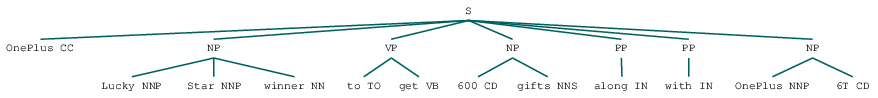

In [45]:
from IPython.display import display
os.environ['PATH'] = os.environ['PATH']+";C:\\Program Files (x86)\\gs\\gs9.26\\bin\\"
display(chunk_tree)